In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

C:\Users\snuist\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Make a saving directory if it doesn't exist
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

## 하이퍼 파라미터 

In [3]:
sess = tf.Session()

batch_size = 500
vocabulary_size = 7500
generations = 100000
model_learning_rate = 0.001

embedding_size = 200   # Word embedding size
doc_embedding_size = 100   # Document embedding size
concatenated_size = embedding_size + doc_embedding_size

num_sampled = int(batch_size/2)    # Number of negative examples to sample.
window_size = 3       # How many words to consider to the left.

# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

## 전처리

In [4]:
# Declare stop words
stops = []

# Test words for validation
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']
# later we will have to transform this into indices

# Load the movie review data
print("Loading data")
texts, target = text_helpers.load_movie_data()

# Normalize text
print("Normalizing Text Data")
texts = text_helpers.normalize_text(texts, stops)

# Text must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > window_size]
texts = [x for x in texts if len(x.split()) > window_size]
assert len(target) == len(texts)
print("Done")

Loading data
Normalizing Text Data
Done


##  딕셔너리 만들기

In [5]:
print("Creating Dictionary")
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]
print("Done.")

Creating Dictionary
Done.


## Doc2Vec model

In [6]:
print("Creating Model")
# Define Embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))

# NCE loss parameters
# We can use tf.matmul(embed, tf.transpose(nce_weights)) + nce_biases
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                             stddev=1.0/np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size+1]) # plus 1 for doc index
y_target = tf.placeholder(tf.int32, shape=[None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32) # 단어의 숫자 인덱스

# Lookup the word embedding
# 원래 embedding lookup을 하면 x_input 중 
# word의 디멘션이 (batch_size, window_size)이므로  (doc의 디멘션은 뺀다. 나중에 concat할 것의므로)
# embed dimension은 (batch_size, window_size, embedding_size)가 되어야 한다.
# 하지만, 여기서는 해당 batch에 있는 단어벡터들의 embedding을 모두 더하므로
# embed의 최종 디멘션은 (batch_size, embedding_size가 된다. )
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:,element])

# tf.slice(input, begin, size_for_each_dimension)
# 아래 tf.slice()의 결과는 x_input에 있는 각 배치에서 마지막 아이템인
# doc_indice를 뽑아오게 한다. 
# 원래 doc_indices의 디멘션이 (batch_size, 1)이었으므로
# doc_embed의 디멘션은 (batch_size, 1, embedding_size)가 된다.
doc_indices = tf.slice(x_inputs, [0, window_size],[batch_size, 1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings, doc_indices)

# Concatenate embeddings
# word_embed와 doc_embed가 붙기 위해서는 doc_embed의 디멘션이
# word_embed의 그것과 마찬가지로 (batch_size, 어쩌구)가 되어야 한다.
# doc_embed의 디멘션에서 중간에 있는 1 디멘션만 없애면 된다.
# 따라서 우리는 tf.squeeze를 써서 그 부분을 없애려 하는 것이다.
# tf.squeeze를 쓰면 어떤 디멘션을 줄이는지 지정해주지 않을 때,
# 1이 있는 디멘션은 모두 없애준다. 
# 하지만 지정을 해준다면 그 1의 값을 갖는 해당 디멘션만 지워준다.
final_embed = tf.concat(axis=1, values=[embed, tf.squeeze(doc_embed)])
print("Done")

Creating Model
Done


## Back Propagation and optimizer

In [7]:
# loss function
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                    biases=nce_biases,
                                    labels=y_target,
                                    inputs=final_embed,
                                    num_sampled=num_sampled,
                                    num_classes=vocabulary_size))

# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optimizer.minimize(loss)

# Consine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings/norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Create model saving operation
saver = tf.train.Saver({"embeddings":embeddings, "doc_embeddings":doc_embeddings})

# Add variable initializer
init = tf.global_variables_initializer()
sess.run(init)

In [8]:
# Run the doc2vec model.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='doc2vec')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(train_step, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 100 : 614.9639282226562
Loss at step 200 : 611.4845581054688
Loss at step 300 : 591.1814575195312
Loss at step 400 : 541.6389770507812
Loss at step 500 : 524.9091186523438
Loss at step 600 : 529.4607543945312
Loss at step 700 : 495.6189270019531
Loss at step 800 : 529.7136840820312
Loss at step 900 : 487.34423828125
Loss at step 1000 : 465.75616455078125
Loss at step 1100 : 464.6290283203125
Loss at step 1200 : 460.97674560546875
Loss at step 1300 : 445.3690185546875
Loss at step 1400 : 421.0588684082031
Loss at step 1500 : 435.6553039550781
Loss at step 1600 : 387.7611999511719
Loss at step 1700 : 424.7847900390625
Loss at step 1800 : 338.6973876953125
Loss at step 1900 : 332.47918701171875
Loss at step 2000 : 378.2123107910156
Loss at step 2100 : 342.57586669921875
Loss at step 2200 : 305.3441162109375
Loss at step 2300 : 340.13189697265625
Loss at step 2400 : 294.1463928222656
Loss at step 2500 : 287.06634521484375
Loss at step 2600 : 302.8504333496094

Loss at step 17600 : 62.378475189208984
Loss at step 17700 : 55.899871826171875
Loss at step 17800 : 66.72975158691406
Loss at step 17900 : 63.774600982666016
Loss at step 18000 : 69.71263885498047
Loss at step 18100 : 53.95854568481445
Loss at step 18200 : 53.27594757080078
Loss at step 18300 : 50.352848052978516
Loss at step 18400 : 62.62276077270508
Loss at step 18500 : 59.44590377807617
Loss at step 18600 : 67.02999877929688
Loss at step 18700 : 52.44969940185547
Loss at step 18800 : 54.339942932128906
Loss at step 18900 : 49.247581481933594
Loss at step 19000 : 55.67815017700195
Loss at step 19100 : 47.56294250488281
Loss at step 19200 : 55.28193664550781
Loss at step 19300 : 57.386653900146484
Loss at step 19400 : 55.351566314697266
Loss at step 19500 : 47.48347091674805
Loss at step 19600 : 46.93040084838867
Loss at step 19700 : 58.639244079589844
Loss at step 19800 : 49.16046905517578
Loss at step 19900 : 44.87997817993164
Loss at step 20000 : 36.28437042236328
Nearest to love:

Loss at step 35000 : 28.236099243164062
Nearest to love: be, are, to, RARE, but,
Nearest to hate: strands, passions, occasionally, any, clarify,
Nearest to happy: attending, charge, long, genteel, tacky,
Nearest to sad: driven, moronic, observe, tortured, actionpacked,
Nearest to man: is, almost, or, glad, performances,
Nearest to woman: powerpuff, coherence, drive, books, lurking,
Model saved in file: C:\Users\snuist\Dlearning\NLP\Tensorflow cookbook\temp\doc2vec_movie_embeddings.ckpt
Loss at step 35100 : 30.843250274658203
Loss at step 35200 : 38.80038070678711
Loss at step 35300 : 29.36174201965332
Loss at step 35400 : 30.354856491088867
Loss at step 35500 : 38.996315002441406
Loss at step 35600 : 34.017574310302734
Loss at step 35700 : 27.18089485168457
Loss at step 35800 : 36.50205993652344
Loss at step 35900 : 39.84877395629883
Loss at step 36000 : 31.25360870361328
Loss at step 36100 : 50.88239669799805
Loss at step 36200 : 42.29478454589844
Loss at step 36300 : 29.4422512054443

Loss at step 51300 : 21.6633243560791
Loss at step 51400 : 24.991497039794922
Loss at step 51500 : 32.39000701904297
Loss at step 51600 : 29.715593338012695
Loss at step 51700 : 27.03644561767578
Loss at step 51800 : 30.23542022705078
Loss at step 51900 : 29.81197738647461
Loss at step 52000 : 25.551414489746094
Loss at step 52100 : 32.0023307800293
Loss at step 52200 : 25.459835052490234
Loss at step 52300 : 18.409833908081055
Loss at step 52400 : 38.874385833740234
Loss at step 52500 : 26.015085220336914
Loss at step 52600 : 23.13489532470703
Loss at step 52700 : 19.07639503479004
Loss at step 52800 : 27.460988998413086
Loss at step 52900 : 24.607036590576172
Loss at step 53000 : 32.497398376464844
Loss at step 53100 : 31.078697204589844
Loss at step 53200 : 28.659963607788086
Loss at step 53300 : 22.4240665435791
Loss at step 53400 : 28.25789451599121
Loss at step 53500 : 36.881595611572266
Loss at step 53600 : 22.936861038208008
Loss at step 53700 : 19.519502639770508
Loss at step 

Loss at step 68700 : 25.975786209106445
Loss at step 68800 : 22.528505325317383
Loss at step 68900 : 26.192556381225586
Loss at step 69000 : 17.041318893432617
Loss at step 69100 : 20.104047775268555
Loss at step 69200 : 16.9153995513916
Loss at step 69300 : 27.229496002197266
Loss at step 69400 : 31.89629364013672
Loss at step 69500 : 27.692493438720703
Loss at step 69600 : 22.68466567993164
Loss at step 69700 : 21.37394142150879
Loss at step 69800 : 22.547122955322266
Loss at step 69900 : 32.86294937133789
Loss at step 70000 : 23.661954879760742
Nearest to love: be, are, to, but, RARE,
Nearest to hate: strands, occasionally, passions, any, miserable,
Nearest to happy: attending, long, charge, genteel, tacky,
Nearest to sad: driven, moronic, tortured, observe, actionpacked,
Nearest to man: is, almost, or, to, performances,
Nearest to woman: powerpuff, coherence, drive, books, lurking,
Model saved in file: C:\Users\snuist\Dlearning\NLP\Tensorflow cookbook\temp\doc2vec_movie_embeddings.

Loss at step 85100 : 24.793386459350586
Loss at step 85200 : 22.561676025390625
Loss at step 85300 : 21.843673706054688
Loss at step 85400 : 17.258975982666016
Loss at step 85500 : 20.693023681640625
Loss at step 85600 : 24.761735916137695
Loss at step 85700 : 20.543113708496094
Loss at step 85800 : 21.092620849609375
Loss at step 85900 : 17.838802337646484
Loss at step 86000 : 20.222084045410156
Loss at step 86100 : 18.02133560180664
Loss at step 86200 : 21.840604782104492
Loss at step 86300 : 16.958091735839844
Loss at step 86400 : 23.5305233001709
Loss at step 86500 : 21.294713973999023
Loss at step 86600 : 20.967578887939453
Loss at step 86700 : 26.29070281982422
Loss at step 86800 : 24.418609619140625
Loss at step 86900 : 18.647348403930664
Loss at step 87000 : 14.579935073852539
Loss at step 87100 : 26.153989791870117
Loss at step 87200 : 18.969894409179688
Loss at step 87300 : 16.85359764099121
Loss at step 87400 : 20.4090518951416
Loss at step 87500 : 21.622209548950195
Loss at

## Logistic model to predict sentiment

### Hyper paremters

In [9]:
max_words = 20
logistic_batch_size = 500

### Get text_data (train, test)

In [30]:
## Need to keep the indices sorted to keep track of document index
train_indices = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace=False))
test_indices = np.sort(np.array(list(set(range(len(target))) - set(train_indices))))

texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# Convert texts to lists of indices
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

# Pad/Crop movie reviews to specific length
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

### Input placeholders and forward propagation

In [12]:
# Define Logistic placeholders
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words+1]) # plus 1 for doc index
log_y_target = tf.placeholder(tf.int32, shape=[None, 1])

# Define logistic embedding lookup (needed if we have two different batch sizes)
# Add together element embeddings in window
log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:,element])

log_doc_indices = tf.slice(log_x_inputs, [0,max_words],[logistic_batch_size,1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings, log_doc_indices)

# Concatenate embeddings
log_final_embed = tf.concat(axis=1, values=[log_embed, tf.squeeze(log_doc_embed)])

# Define model
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[concatenated_size, 1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(log_final_embed, A), b)


### Loss function and Optimizer

In [16]:
# Declare loss function
# 계산을 위해서 tf.int32로 지정되었던 log_y_target을 tf.cast를 통해 
# tf.float32로 바꿔준다.
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=tf.cast(log_y_target, tf.float32)))

# Actual prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A,b]) # var_list= variable list

# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [31]:
np.hstack((rand_x, np.transpose([rand_x_doc_indices])))

array([[list([1, 3217, 2058, 7059, 4, 1, 4451, 4, 1, 2822, 4452, 6, 36, 1057, 8, 2, 7060, 4, 765, 828, 4453, 2520, 7061, 1058, 5418, 4454, 642, 4, 1231, 2823, 2823, 7062, 0]),
        list([669, 12, 0, 1885]),
        list([37, 21, 246, 27, 5, 189, 5, 1, 66, 5, 35, 129, 7063, 6, 2, 52, 309, 5, 643]),
        ..., list([457, 958, 9, 134, 869, 669]), 1, 1],
       [list([1, 3217, 2058, 7059, 4, 1, 4451, 4, 1, 2822, 4452, 6, 36, 1057, 8, 2, 7060, 4, 765, 828, 4453, 2520, 7061, 1058, 5418, 4454, 642, 4, 1231, 2823, 2823, 7062, 0]),
        list([669, 12, 0, 1885]),
        list([37, 21, 246, 27, 5, 189, 5, 1, 66, 5, 35, 129, 7063, 6, 2, 52, 309, 5, 643]),
        ..., list([457, 958, 9, 134, 869, 669]), 1, 1],
       [list([1, 3217, 2058, 7059, 4, 1, 4451, 4, 1, 2822, 4452, 6, 36, 1057, 8, 2, 7060, 4, 765, 828, 4453, 2520, 7061, 1058, 5418, 4454, 642, 4, 1231, 2823, 2823, 7062, 0]),
        list([669, 12, 0, 1885]),
        list([37, 21, 246, 27, 5, 189, 5, 1, 66, 5, 35, 129, 7063, 6, 2, 5

### Logistic Regression training for sentiment

In [32]:
print("Starting Logistic Doc2Vec Model Training")
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []

for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
    rand_x = text_data_train[rand_index] # dim: (logistic_batch_size, max_words)    # Append review index at the end of text data
    # 아래 rand_x_doc_indices 코드에 대한 설명
    # train_indices들은 target에서 랜덤하게 뽑힌 80%의 자료들이다.
    # 그것들은 아래 ref) indices를 보면 내부적으로 순서대로 0,1,2,3의 index로 불러올 수 있다
    # rand_x_doc_indices는 len(train_indices)보다 작은 수 중 랜덤한 수들로
    # index삼아서 train_indices(doc_indices)를 뽑아내는 것이다.
    rand_x_doc_indices = train_indices[rand_index] 
    # rand_x dim: (logistic_batch_size, max_words+1)
    # rand_y dim: (logistic_batch_size, 1)
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
    rand_y = np.transpose([target_train[rand_index]])
    
    feed_dict = {log_x_inputs: rand_x, log_y_target: rand_y}
    sess.run(logistic_train_step, feed_dict=feed_dict)
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100 ==0:
        rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
        rand_x_test = text_data_test[rand_index_test]
        # Append review index at the end of text data
        rand_x_doc_indices_test = test_indices[rand_index_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
        rand_y_test = np.transpose([target_test[rand_index_test]])
        
        test_feed_dict = {log_x_inputs: rand_x_test, log_y_target: rand_y_test}
        
        i_data.append(i+1)
        
        train_loss_temp = sess.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        test_loss_temp = sess.run(logistic_loss, feed_dict=test_feed_dict)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
        test_acc_temp = sess.run(accuracy, feed_dict=test_feed_dict)
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:2f} ({:2f}). Train Acc (Test Acc): {:2f} ({:2f})'.format(*acc_and_loss))

Starting Logistic Doc2Vec Model Training
Generation # 500. Train Loss (Test Loss): 6.950000 (6.680000). Train Acc (Test Acc): 0.570000 (0.510000)
Generation # 1000. Train Loss (Test Loss): 4.530000 (4.650000). Train Acc (Test Acc): 0.550000 (0.580000)
Generation # 1500. Train Loss (Test Loss): 3.480000 (3.550000). Train Acc (Test Acc): 0.520000 (0.560000)
Generation # 2000. Train Loss (Test Loss): 2.380000 (3.040000). Train Acc (Test Acc): 0.620000 (0.530000)
Generation # 2500. Train Loss (Test Loss): 2.740000 (3.500000). Train Acc (Test Acc): 0.600000 (0.530000)
Generation # 3000. Train Loss (Test Loss): 2.390000 (2.830000). Train Acc (Test Acc): 0.560000 (0.530000)
Generation # 3500. Train Loss (Test Loss): 2.130000 (2.430000). Train Acc (Test Acc): 0.570000 (0.540000)
Generation # 4000. Train Loss (Test Loss): 2.080000 (2.350000). Train Acc (Test Acc): 0.570000 (0.530000)
Generation # 4500. Train Loss (Test Loss): 2.360000 (3.090000). Train Acc (Test Acc): 0.600000 (0.540000)
Genera

#### ref) indices

In [19]:
train_indices

array([    1,     2,     3, ..., 10450, 10451, 10452])

In [22]:
train_indices[5]

7

### Plotting train/test loss and accuracy

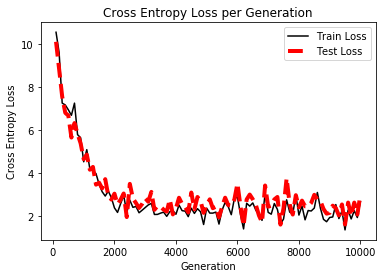

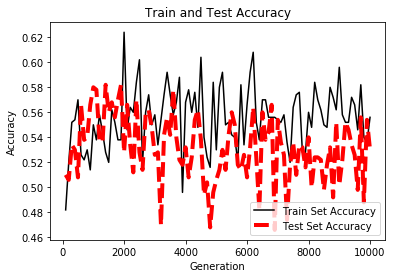

In [33]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()